# 1. Settings

## 1.1 User variables

In [1]:
from config import *

NB_RUNS = 30

HEURISTICS = ["try_all_atoms", "max_coverage_static"] #["max_coverage_static"] #["try_all_atoms", "max_coverage_dynamic", "max_coverage_static", "max_diversity"]
USE_NAN = True

# 1.2 Dev variables

In [2]:
RANDOM_SEED = 0

INPUT_DATA_DISCRETE = "tmp/data_discrete.csv"
OUTPUT_CSV = "tmp/lfit_output.csv"

VERBOSE = True

USE_GULA = True

## 1.3 Imports

In [3]:
import pandas as pd
import numpy
import random
import pylfit
import os

from config import *

random.seed(RANDOM_SEED)
numpy.random.seed(RANDOM_SEED)

## 1.4 Constants

In [4]:
# Constants
DEBUG = False

# 2. Data Loading

# DEBUG

In [5]:
# DEBUG
print("Training dataset:")
df = pd.read_csv(DISCRETE_DATA_PATH)
cols = [c for c in df.columns if c not in TARGETS]

#df = df.drop(columns=["Poaceae_prev"])

display(df)

# DBG
#FEATURES = [c for c in df.columns if c not in TARGETS]

Training dataset:


,M15,Picea,Pinus,Betula,Quercus,Ulmus,Ambrosia,Artemesia,Chenopodiaceae,Cyperaceae,...,Picea_change,Pinus_change,Betula_change,Quercus_change,Ulmus_change,Ambrosia_change,Artemesia_change,Chenopodiaceae_change,Cyperaceae_change,Poaceae_change
0,0,2,1,0,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,2,2,0,0,0,1,0,0,1,...,-1,1,1,-1,-1,0,-1,-1,0,0
2,0,2,2,0,0,1,0,1,0,1,...,0,-1,-1,1,1,-1,1,1,-1,0
3,1,2,0,1,1,0,0,1,1,0,...,-1,-1,1,1,-1,-1,0,1,0,0
4,2,2,1,0,0,0,0,0,0,0,...,1,1,-1,-1,1,0,-1,-1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0,2,0,2,1,2,1,2,0,0,...,1,-1,0,1,1,1,1,-1,-1,1
58,0,2,0,2,0,2,0,2,2,0,...,-1,1,-1,-1,1,-1,0,1,0,1
59,0,2,2,0,0,0,2,2,2,0,...,-1,1,-1,0,-1,1,1,1,0,-1
60,0,2,1,0,0,2,1,0,2,1,...,1,-1,-1,0,1,-1,-1,-1,1,0


In [6]:
# Load training dataset
cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
df[cols] = df[cols].astype('Int64')
df[cols] = df[cols].astype('string')

if not USE_NAN:
    df = df.dropna()
else:
    df = df.fillna("?")

col_order = list(df.columns)

df_output = pd.DataFrame(columns=["head_variable", "head_value", "nb_supports", "rule", "supports", "rule_str"])

df.to_csv("tmp/lfit_input.csv")

# Convert array data as a DiscreteStateTransitionsDataset using pylfit.preprocessing
dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv", \
feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])

# Initialize a DMVLP with the dataset variables and set GULA as learning algorithm
model = pylfit.models.DMVLP(features=dataset.features, targets=dataset.targets)
model.compile(algorithm="gula") # model.compile(algorithm="pride")
model.fit(dataset=dataset, options={"heuristics":HEURISTICS, "verbose":1, "threads":THREADS, "supported_only":True})

Starting fit with GULA

Converting transitions to nparray...
Sorting transitions...
Grouping transitions by initial state...
Start learning over 32 threads


In [7]:
def supports(rules, dataset):
    """
    Extract feature state where each rule apply. Dataset must be same as the one that train the rules.
    """
    output = dict()

    for r in rules:
        supports = []
        for s1,s2 in dataset.data:
            if r.matches(s1) and r.head.matches(s2):
                supports += [(s1,s2)]
        output[r] = supports

    return output

def extract_influences(rules, dataset):
    rules_supports = supports(rules, dataset)

    data = []
    for r in rules:
        data.append([r.head.variable, r.head.value, len(rules_supports[r]), r, [(tuple(s1),tuple(s2)) for s1,s2 in rules_supports[r]], r.to_string()])
    
    df = pd.DataFrame(data, columns=["head_variable", "head_value", "nb_supports", "rule", "supports", "rule_str"])
    df_output = pd.DataFrame([], columns=["target", "feature", "positive_influence", "negative_influence", "influence"])

    for target,vals in dataset.targets:
        df_tmp = df[df["head_variable"] == target]
        influences = {}

        # Extract inhibitions
        df_0 = df_tmp[df_tmp["head_value"] == "-1"]

        for idx, row in df_0.iterrows():
            rule = row["rule"]

            for feature in rule.body:
                label = rule.body[feature].to_string()
                if label not in influences:
                    influences[label] = {"negative": 0, "positive":0}
                influences[label]["negative"] += row["nb_supports"] / rule.size()

        # Extract activations
        df_1 = df_tmp[df_tmp["head_value"] == "1"]

        for idx, row in df_1.iterrows():
            rule = row["rule"]

            for feature in rule.body:
                label = rule.body[feature].to_string()
                if label not in influences:
                    influences[label] = {"negative": 0, "positive":0}
                influences[label]["positive"] += row["nb_supports"] / rule.size()

        # Build output dataframe
        data = []
        for var in influences:
            data += [[target, var, influences[var]["positive"], influences[var]["negative"]]]

        df_tmp = pd.DataFrame(data, columns=["target", "feature", "positive_influence", "negative_influence"])
        df_tmp["influence"] = df_tmp["positive_influence"] - df_tmp["negative_influence"]
        df_tmp["influence"] = df_tmp["influence"].astype(int)
        df_output = pd.concat([df_output,df_tmp])

    df_output = df_output.sort_values(by=["influence"],ascending=False)
    
    return df_output

In [8]:
rules_supports = supports(model.rules,dataset)

# Save rules
rules_data = []

for r in model.rules:
    rules_data.append([r.head.variable, r.head.value, len(rules_supports[r]), r, [(tuple(s1),tuple(s2)) for s1,s2 in rules_supports[r]], r.to_string()]) #, r.to_string()])

df_output = pd.DataFrame(rules_data, columns=df_output.columns) #, "rule_raw_form"])

nb_rules_of_run = len(df_output)

print("rules found:", len(df_output))

df_output.to_csv(OUTPUT_CSV,index=False)

display(df_output)

rules found: 25722


,head_variable,head_value,nb_supports,rule,supports,rule_str
0,M15_change,-1,2,"M15_change(-1) :- Ambrosia(1), Poaceae(2).","[((2, 1, 0, 1, 1, 2, 1, 0, 0, 2, 2), (-1, -1, ...","M15_change(-1) :- Ambrosia(1), Poaceae(2)."
1,M15_change,-1,5,"M15_change(-1) :- Chenopodiaceae(0), Poaceae(2).","[((1, 1, 1, 1, 0, 1, 0, 2, 0, 0, 2), (-1, -1, ...","M15_change(-1) :- Chenopodiaceae(0), Poaceae(2)."
2,M15_change,-1,2,"M15_change(-1) :- Artemesia(0), Pinus(0).","[((2, 1, 0, 1, 1, 2, 1, 0, 0, 2, 2), (-1, -1, ...","M15_change(-1) :- Artemesia(0), Pinus(0)."
3,M15_change,-1,1,"M15_change(-1) :- Betula(0), Picea(2), Pinus(0).","[((0, 2, 0, 0, 1, 1, 0, 1, 0, 1, 0), (-1, 1, -...","M15_change(-1) :- Betula(0), Picea(2), Pinus(0)."
4,M15_change,-1,2,"M15_change(-1) :- Ambrosia(1), Chenopodiaceae(...","[((0, 0, 0, 2, 2, 0, 1, 1, 2, 1, 1), (-1, 1, -...","M15_change(-1) :- Ambrosia(1), Chenopodiaceae(..."
...,...,...,...,...,...,...
25717,Poaceae_change,1,3,"Poaceae_change(1) :- Ambrosia(2), Betula(1), C...","[((2, 0, 0, 1, 2, 2, 2, 1, 1, 2, 2), (1, 1, -1...","Poaceae_change(1) :- Ambrosia(2), Betula(1), C..."
25718,Poaceae_change,1,1,"Poaceae_change(1) :- Chenopodiaceae(0), M15(2)...","[((2, 2, 1, 0, 1, 1, 0, 0, 0, 2, 1), (1, 0, -1...","Poaceae_change(1) :- Chenopodiaceae(0), M15(2)..."
25719,Poaceae_change,1,2,"Poaceae_change(1) :- Cyperaceae(2), M15(2), Po...","[((2, 1, 0, 1, 1, 2, 1, 0, 0, 2, 2), (-1, -1, ...","Poaceae_change(1) :- Cyperaceae(2), M15(2), Po..."
25720,Poaceae_change,1,1,"Poaceae_change(1) :- Chenopodiaceae(0), M15(2)...","[((2, 1, 0, 1, 1, 2, 1, 0, 0, 2, 2), (-1, -1, ...","Poaceae_change(1) :- Chenopodiaceae(0), M15(2)..."


In [9]:
"""
# Load training dataset
cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
df[cols] = df[cols].astype('Int64')
df[cols] = df[cols].astype('string')

if not USE_NAN:
    df = df.dropna()
else:
    df = df.fillna("?")

col_order = list(df.columns)

df_output = pd.DataFrame(columns=["head_variable", "head_value", "nb_supports", "rule", "supports", "rule_str"])

if USE_GULA:
    df.to_csv("tmp/lfit_input.csv")

    # Convert array data as a DiscreteStateTransitionsDataset using pylfit.preprocessing
    dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv", \
    feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])

    # Initialize a DMVLP with the dataset variables and set GULA as learning algorithm
    model = pylfit.models.DMVLP(features=dataset.features, targets=dataset.targets)
    model.compile(algorithm="gula") # model.compile(algorithm="pride")
    model.fit(dataset=dataset, options={"heuristics":HEURISTICS, "verbose":1, "threads":THREADS, "supported_only":True})
    rules_supports = pylfit.postprocessing.influences.supports(model.rules,dataset)

    # Save rules
    rules_data = []

    for r in model.rules:
        rules_data.append([r.head.variable, r.head.value, len(rules_supports[r]), r, [(tuple(s1),tuple(s2)) for s1,s2 in rules_supports[r]], r.to_string()]) #, r.to_string()])

    df_output = pd.DataFrame(rules_data, columns=df_output.columns) #, "rule_raw_form"])

    nb_rules_of_run = len(df_output)
    
    print("rules found:", len(df_output))

    df_output.to_csv(OUTPUT_CSV,index=False)

else:

    FEATURES = [c for c in df.columns if c not in TARGETS]
    original_dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv", \
    feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])

    for run_id in range(NB_RUNS):
        # Shuffle variables
        random.shuffle(col_order)
        df = df[col_order]

        FEATURES = [c for c in df.columns if c not in TARGETS]

        df.to_csv("tmp/lfit_input.csv")

        # Convert array data as a DiscreteStateTransitionsDataset using pylfit.preprocessing
        dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv", \
        feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])

        # Initialize a DMVLP with the dataset variables and set GULA as learning algorithm
        model = pylfit.models.DMVLP(features=dataset.features, targets=dataset.targets)
        model.compile(algorithm="pride") # model.compile(algorithm="pride")
        model.fit(dataset=dataset, options={"heuristics":HEURISTICS, "verbose":0, "threads":THREADS})
        rules_supports = pylfit.postprocessing.influences.supports(original_dataset)

        # Save rules
        rules_data = []

        for r in model.rules:
            rules_data.append([r.head.variable, r.head.value, len(rules_supports[r]), r, [(tuple(s1),tuple(s2)) for s1,s2 in rules_supports[r]], r.to_string()]) #, r.to_string()])

        df_rules = pd.DataFrame(rules_data, columns=df_output.columns) #, "rule_raw_form"])

        nb_rules_of_run = len(df_rules)
        nb_rules_total_before = len(df_output)

        df_output = pd.concat([df_output,df_rules]).reset_index(drop=True)
        df_output.drop_duplicates(subset=["rule_str"], inplace=True)

        nb_new_rules = len(df_output) - nb_rules_total_before
        nb_duplicate_rules = nb_rules_of_run - nb_new_rules
        
        print("Run",str(run_id+1)+"/"+str(NB_RUNS),"- new rules found:", nb_new_rules, "- total:",len(df_output),"- duplicate:",nb_duplicate_rules)

    df_output = df_output[["head_variable", "head_value", "nb_supports", "rule", "supports"]]
    df_output.to_csv(OUTPUT_CSV,index=False)

df_output = df_output.sort_values(["nb_supports"],ascending=False)

display(df_output[df_output["head_value"] == "0"])
display(df_output[df_output["head_value"] == "1"])
"""

'\n# Load training dataset\ncols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]\ndf[cols] = df[cols].astype(\'Int64\')\ndf[cols] = df[cols].astype(\'string\')\n\nif not USE_NAN:\n    df = df.dropna()\nelse:\n    df = df.fillna("?")\n\ncol_order = list(df.columns)\n\ndf_output = pd.DataFrame(columns=["head_variable", "head_value", "nb_supports", "rule", "supports", "rule_str"])\n\nif USE_GULA:\n    df.to_csv("tmp/lfit_input.csv")\n\n    # Convert array data as a DiscreteStateTransitionsDataset using pylfit.preprocessing\n    dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv",     feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])\n\n    # Initialize a DMVLP with the dataset variables and set GULA as learning algorithm\n    model = pylfit.models.DMVLP(features=dataset.features, targets=dataset.targets)\n    model.compile(algorithm="gula") # model.compile(algorithm="pride")\n    mod

# Influence Graph extraction

In [10]:
df_influences = extract_influences(model.rules,dataset)
df_influences

C:\Users\Tony\AppData\Local\Temp\ipykernel_31508\1628047429.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output,df_tmp])


,target,feature,positive_influence,negative_influence,influence
32,M15_change,M15(2),93.166667,14.000000,79
20,Ulmus_change,Ulmus(2),79.833333,9.033333,70
10,Poaceae_change,Poaceae(2),79.083333,9.700000,69
8,Pinus_change,Pinus(2),85.166667,16.366667,68
17,Pinus_change,Artemesia(0),75.250000,26.116667,49
...,...,...,...,...,...
14,Poaceae_change,Poaceae(0),9.916667,59.000000,-49
23,M15_change,M15(0),15.266667,69.583333,-54
30,Artemesia_change,Artemesia(0),5.000000,70.333333,-65
22,Betula_change,Artemesia(0),22.666667,93.250000,-70


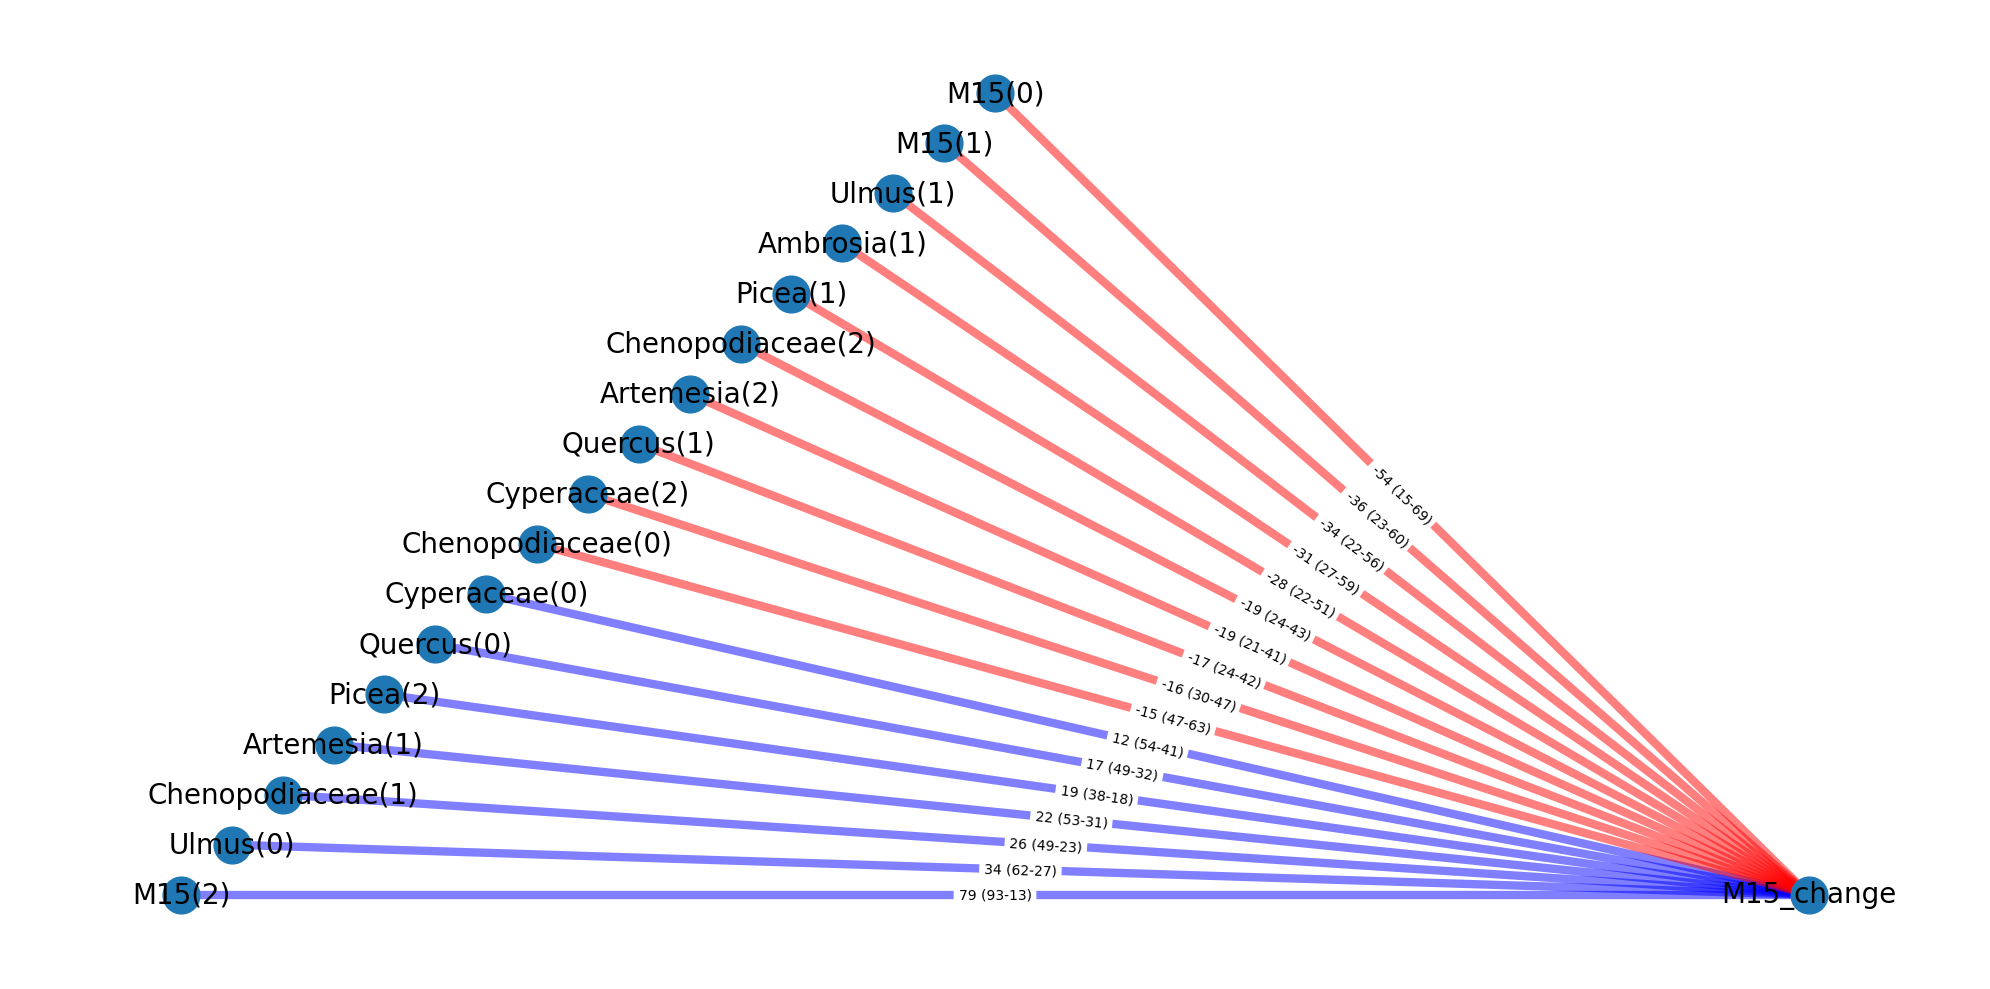

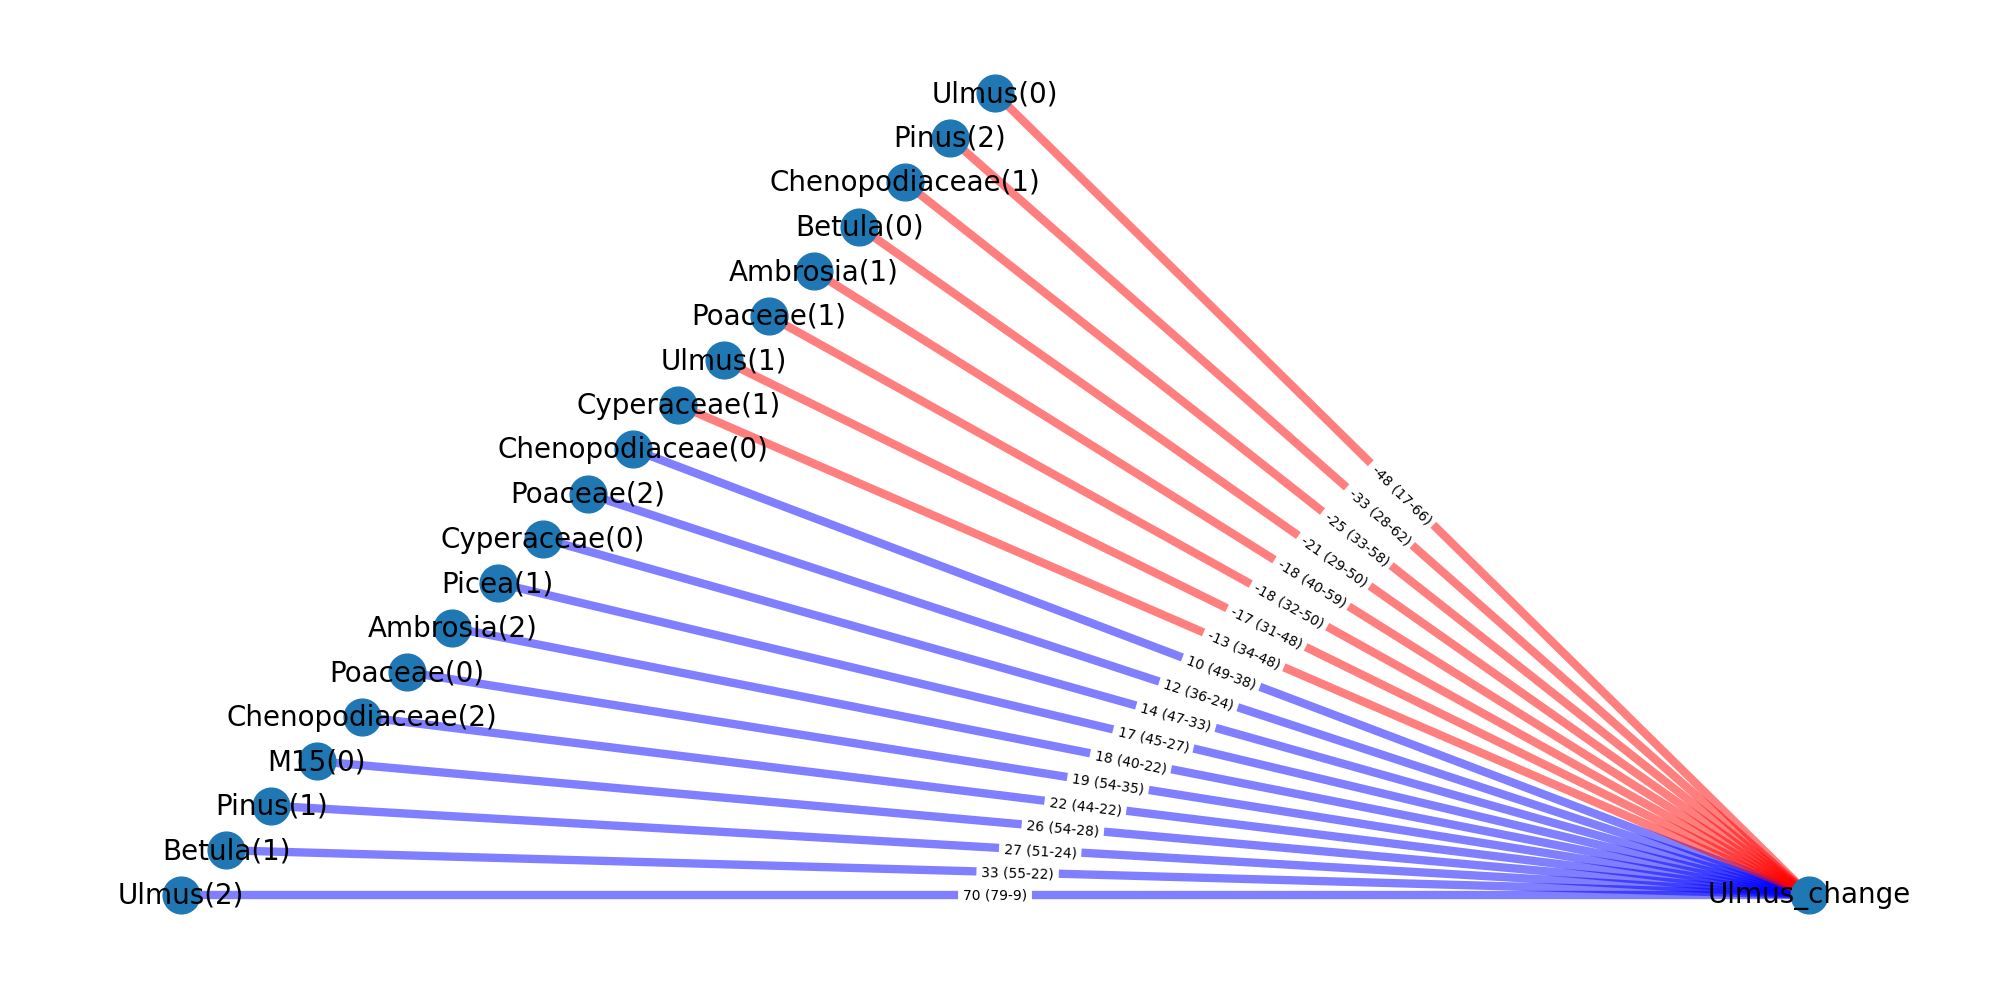

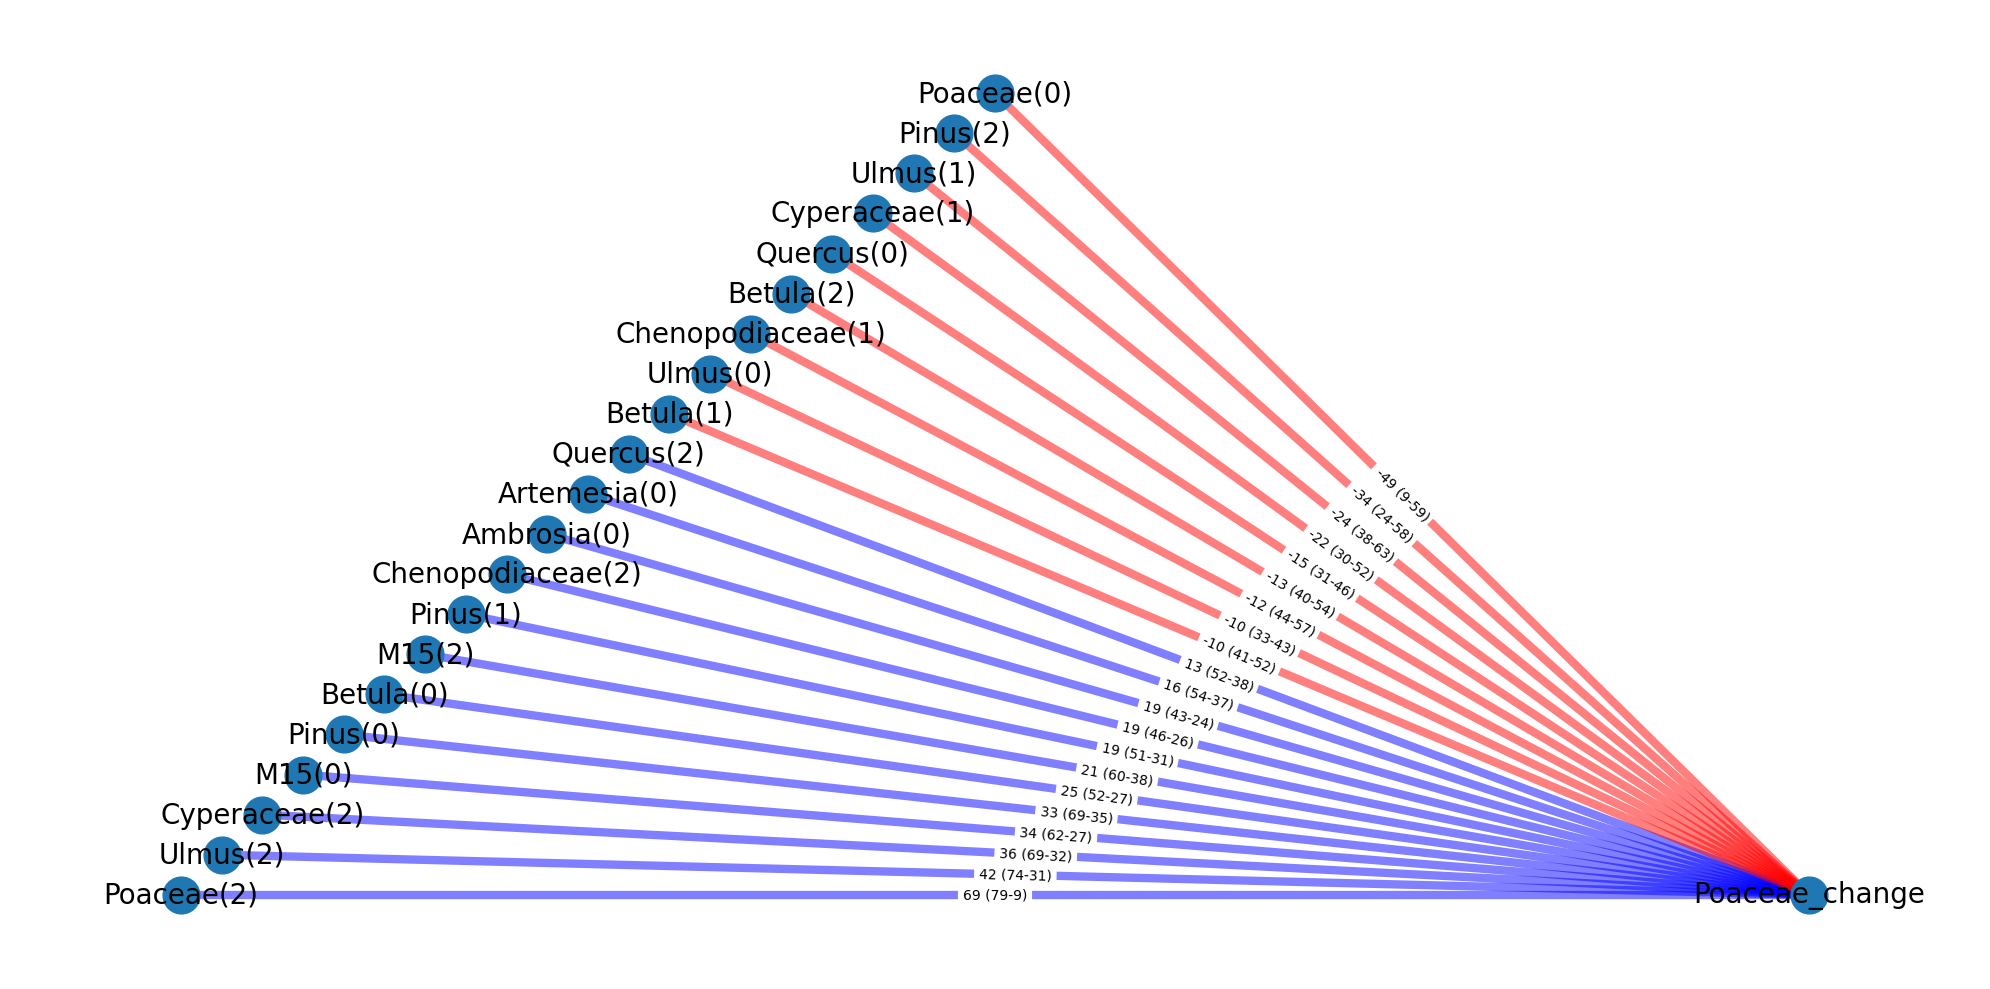

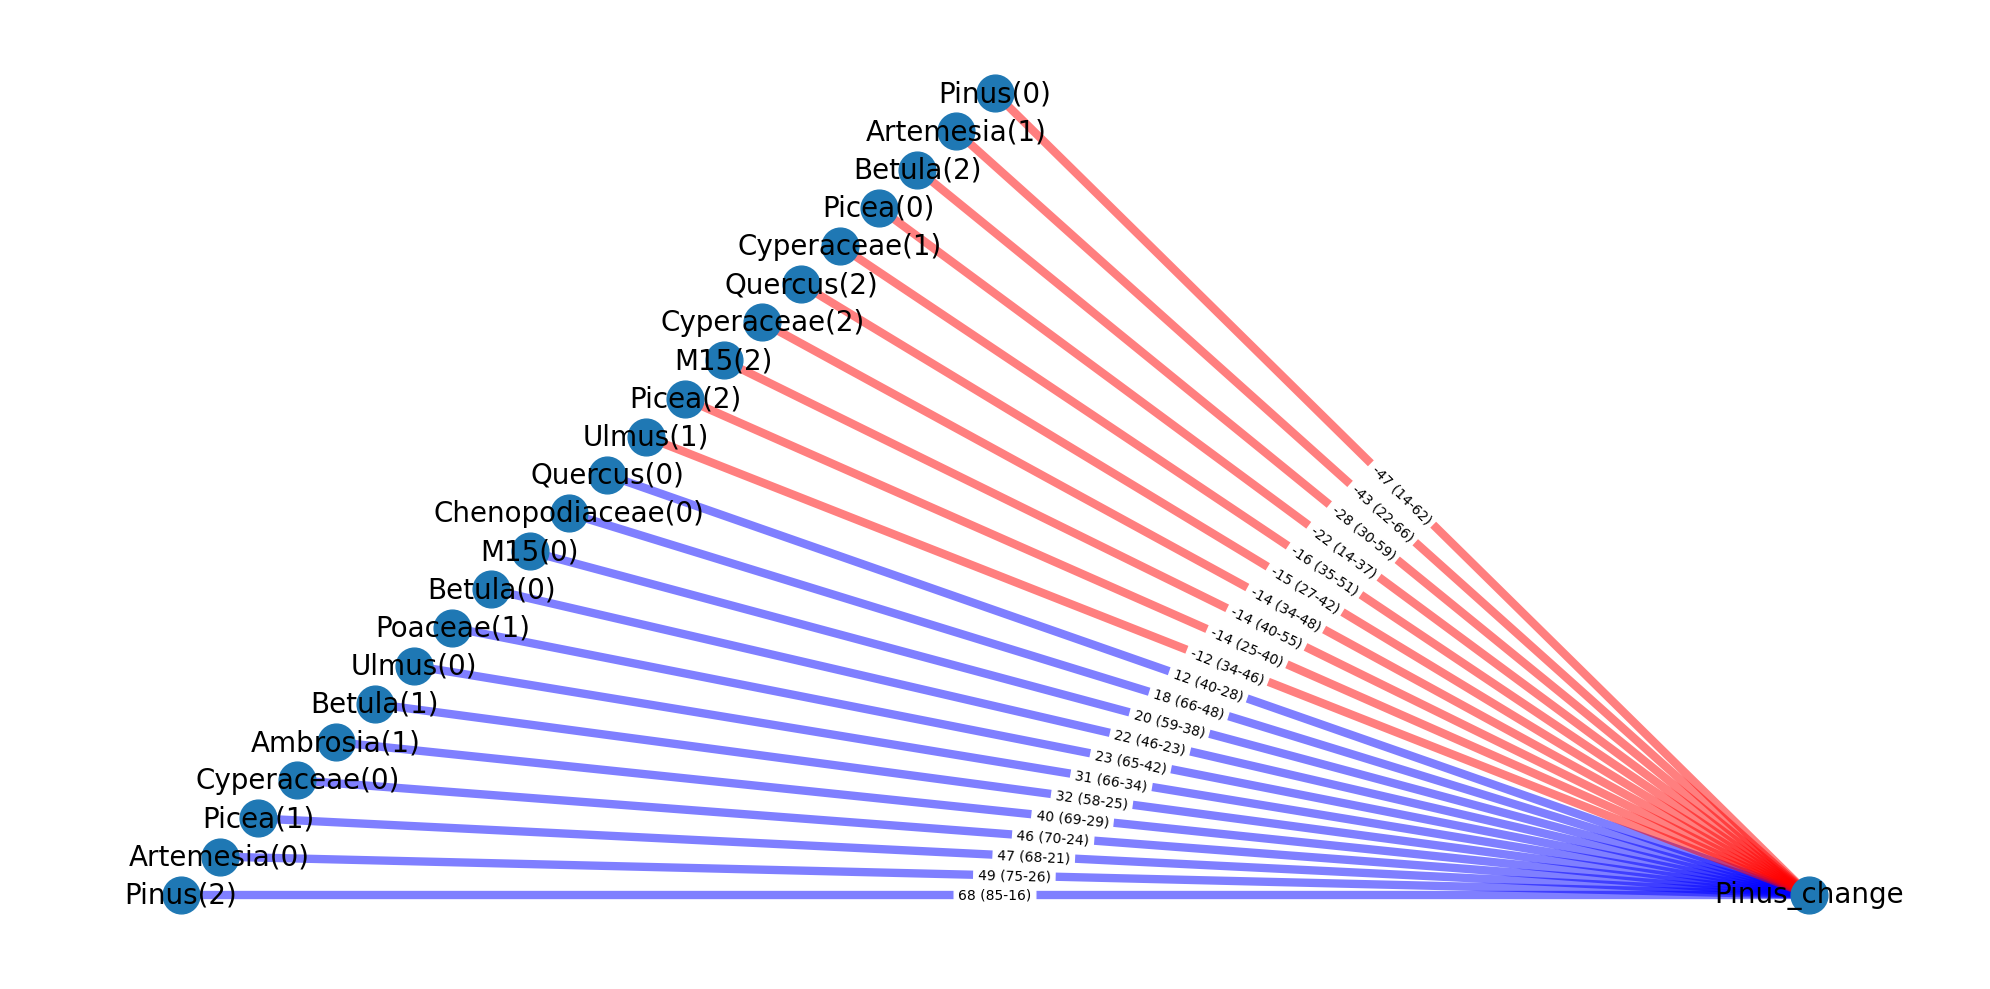

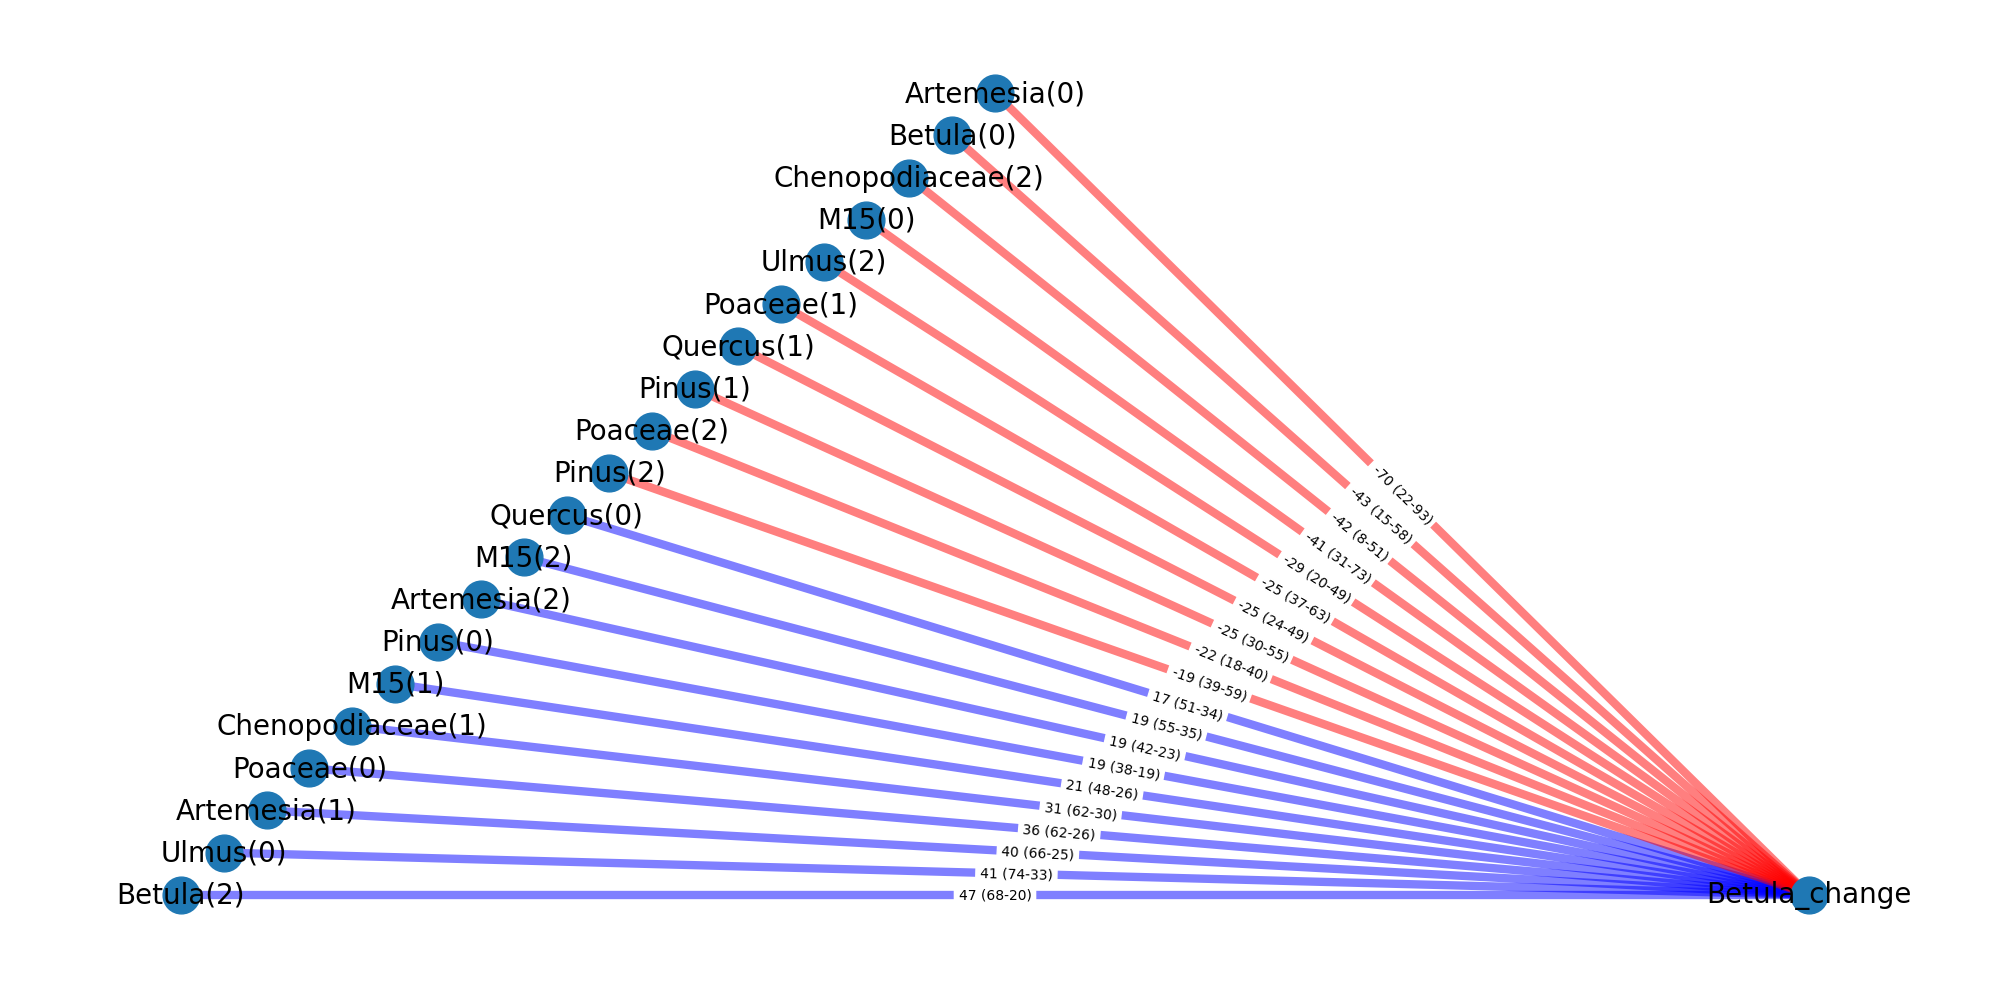

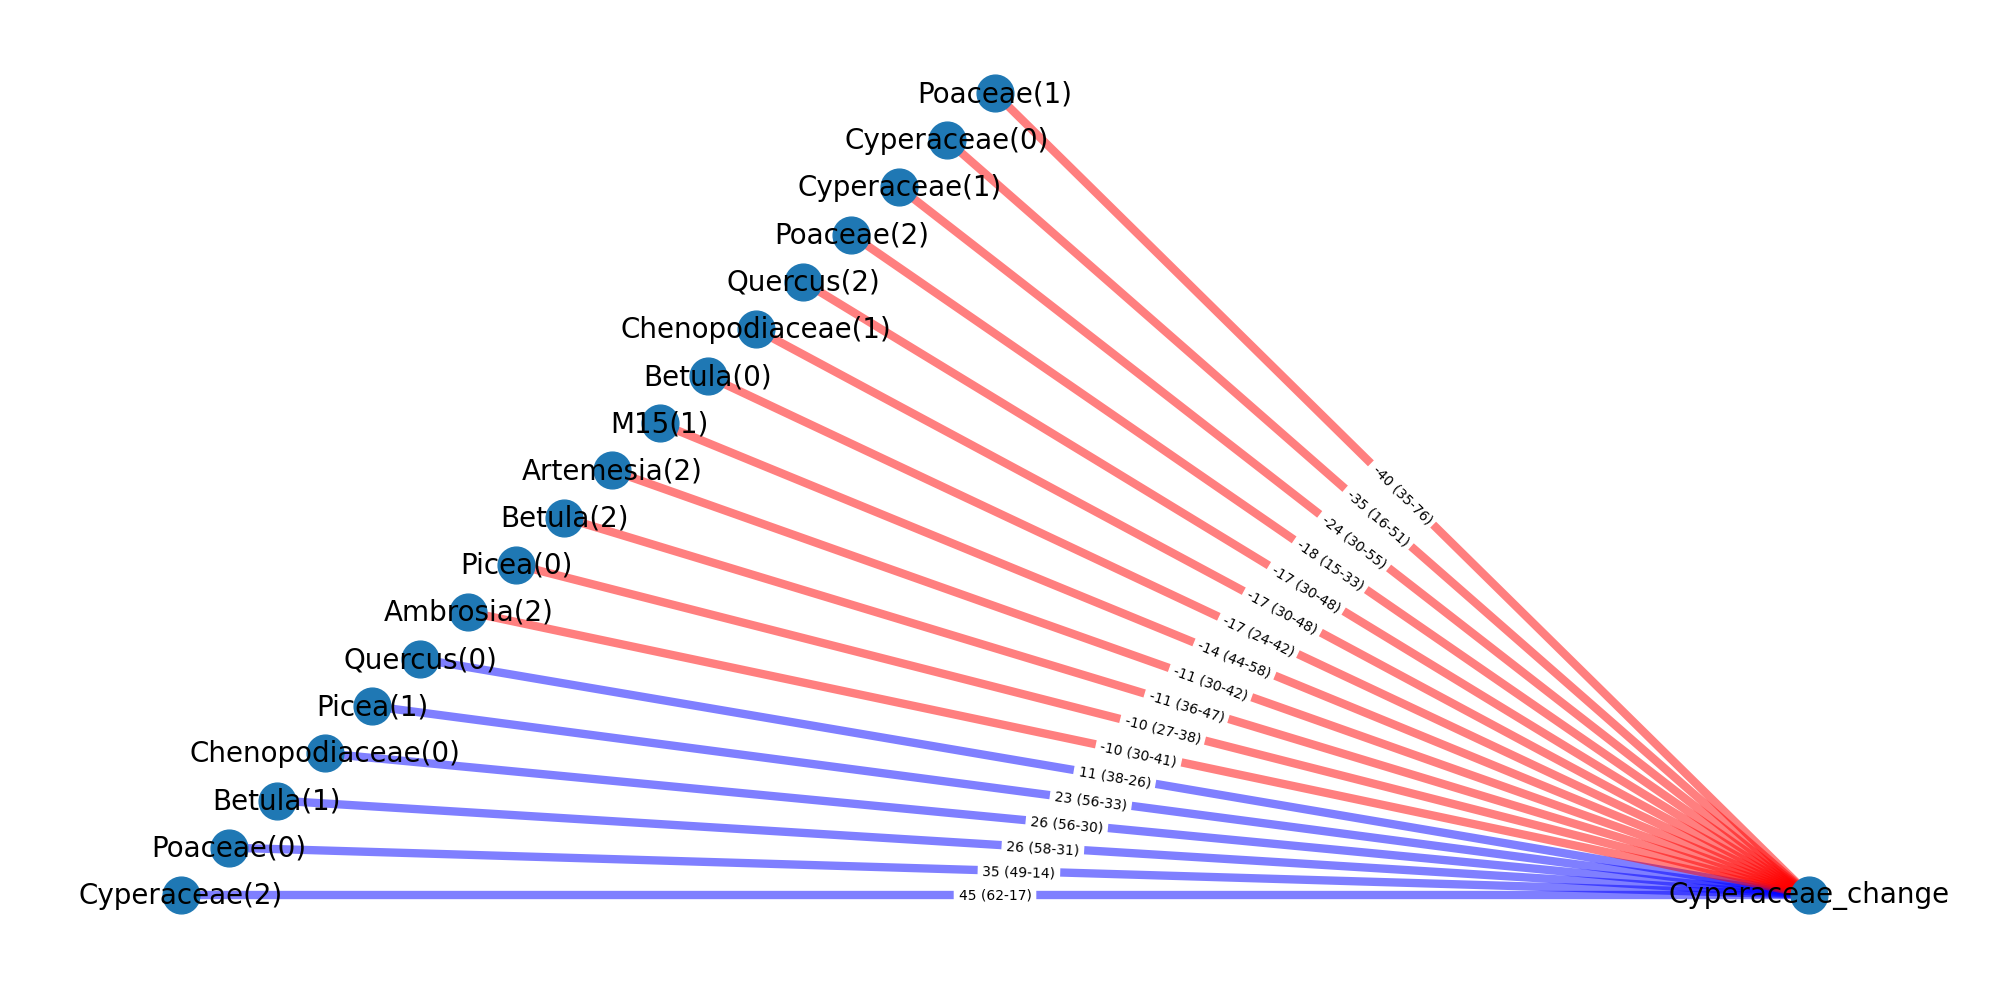

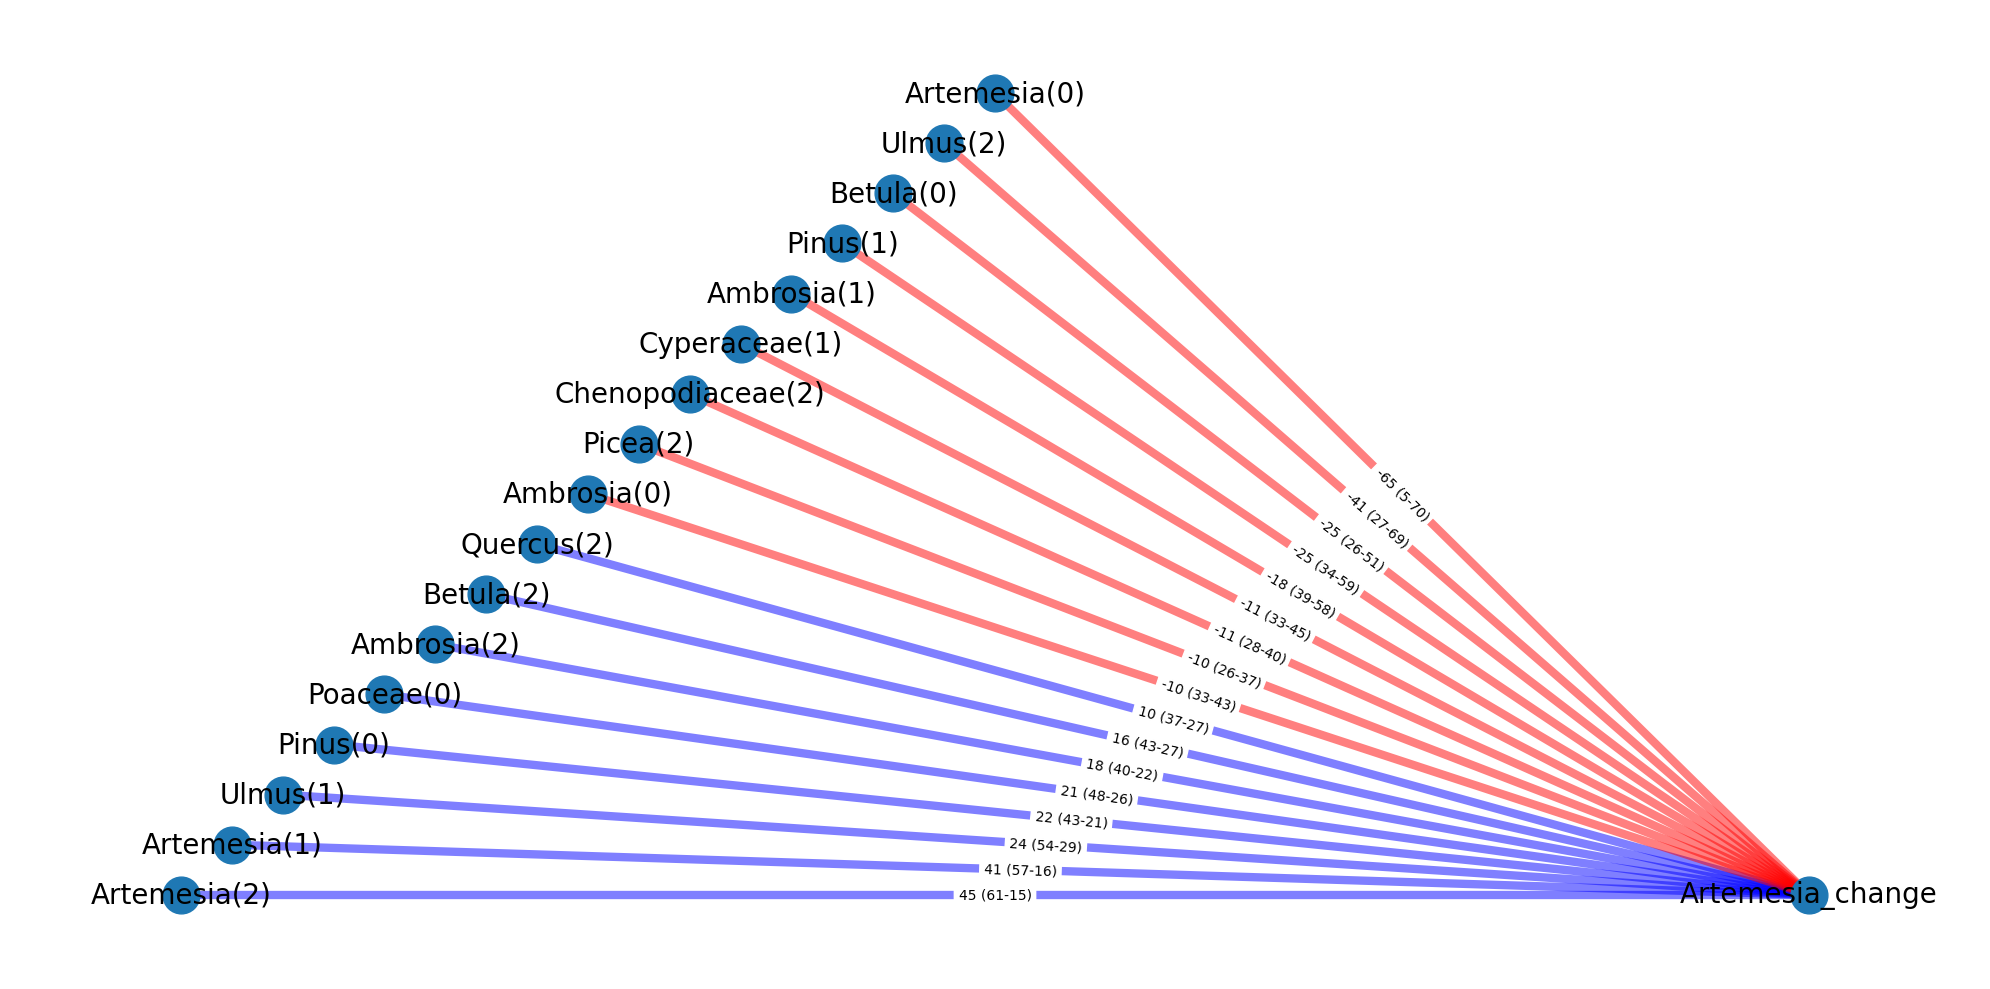

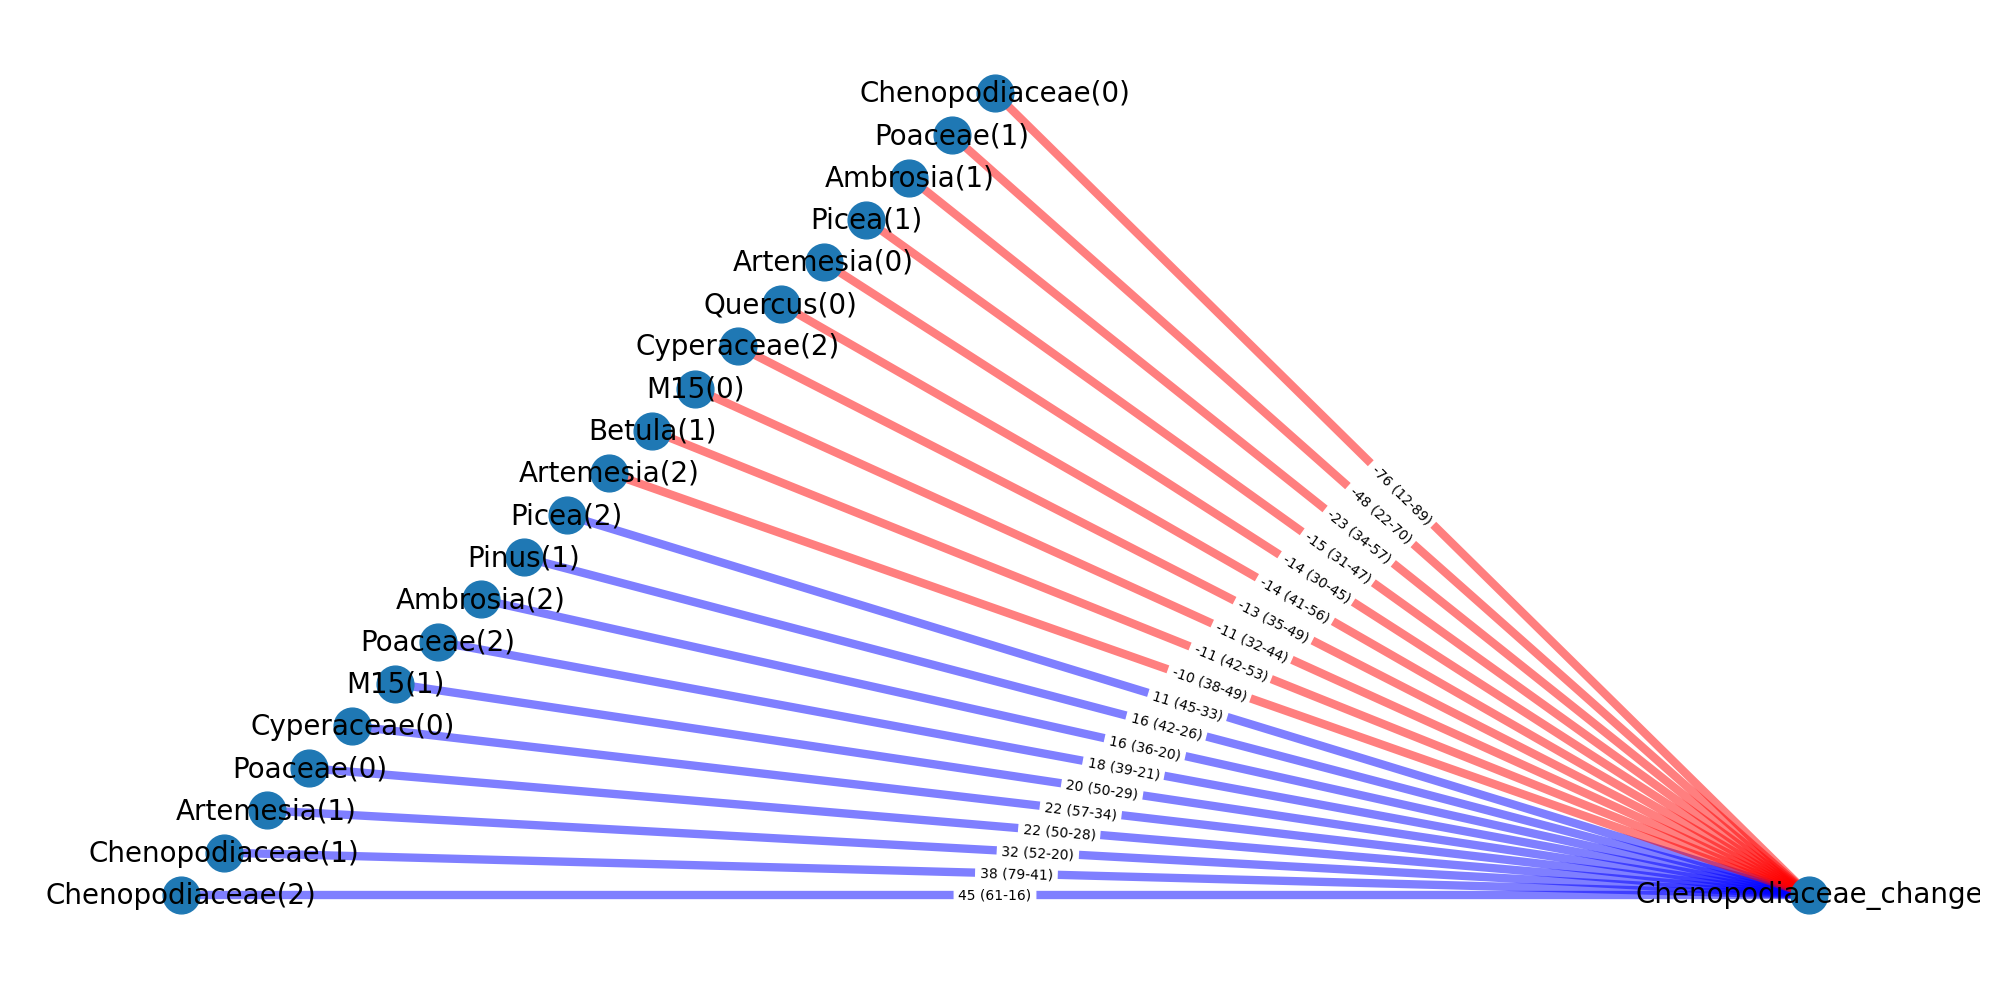

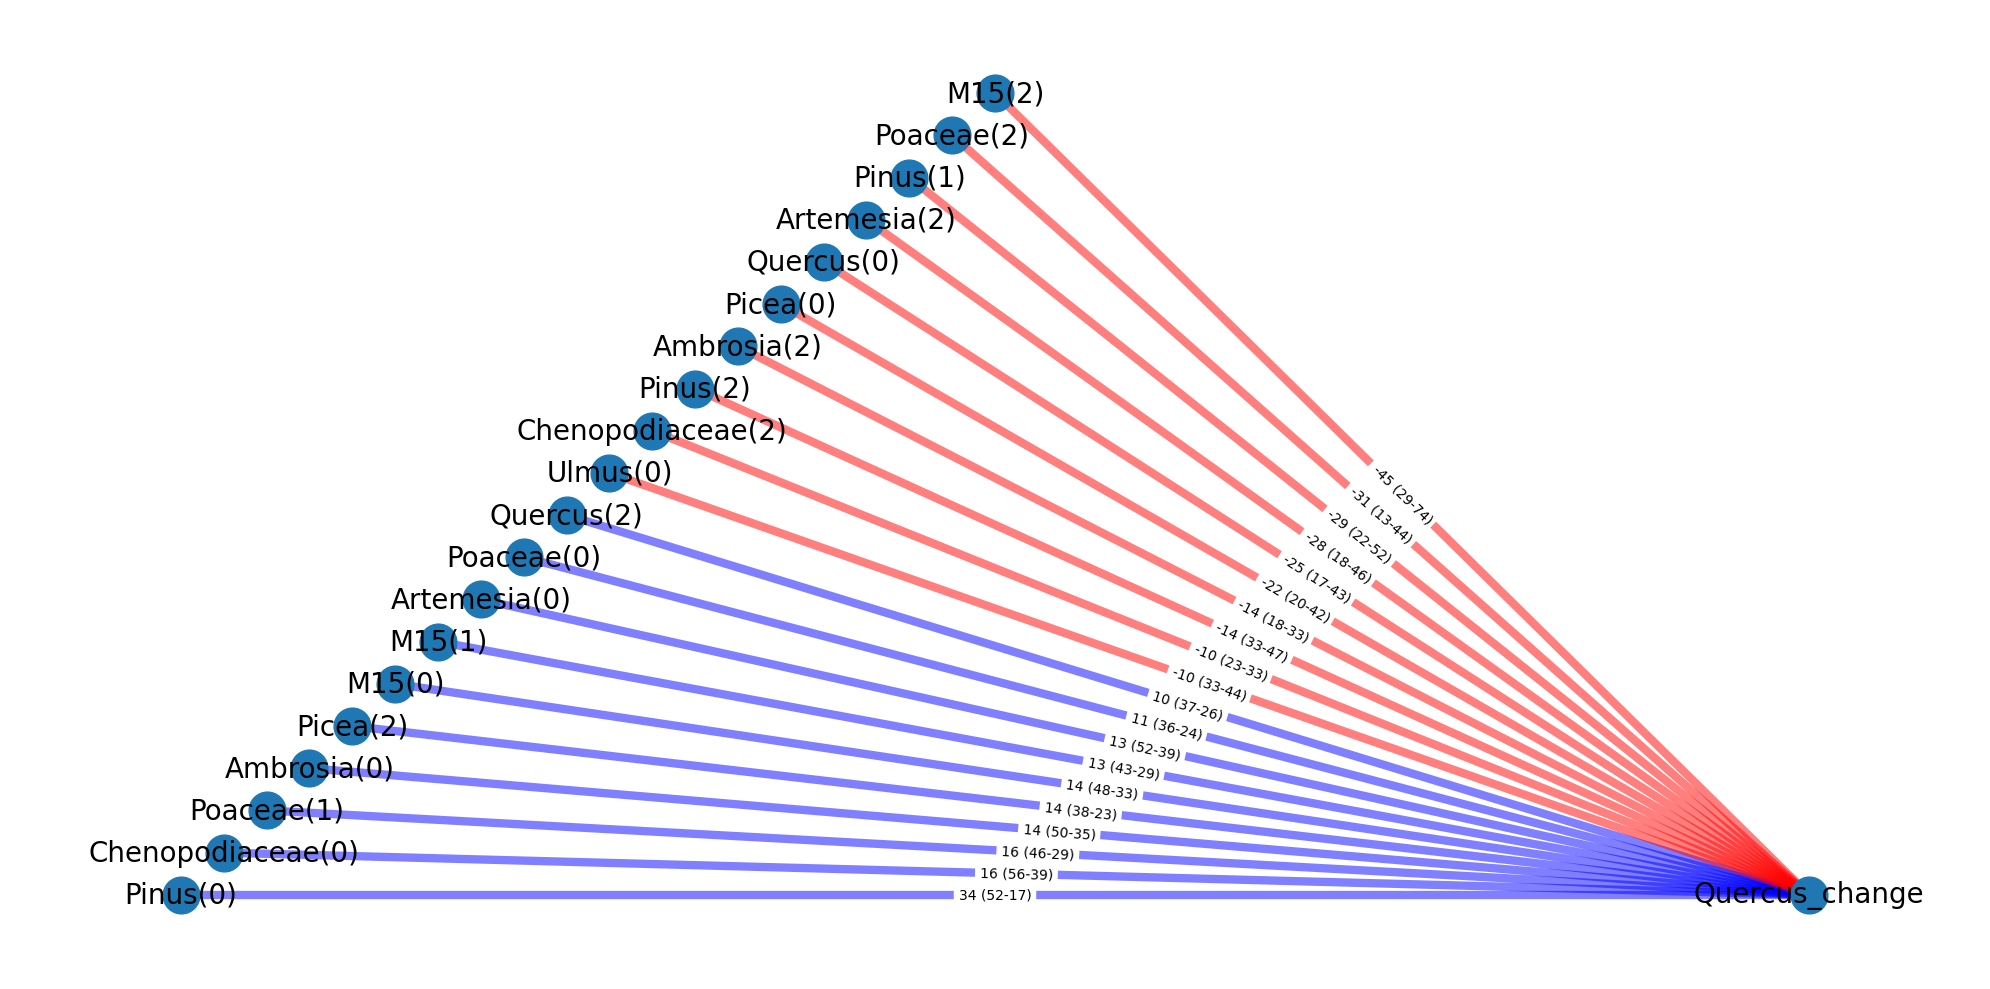

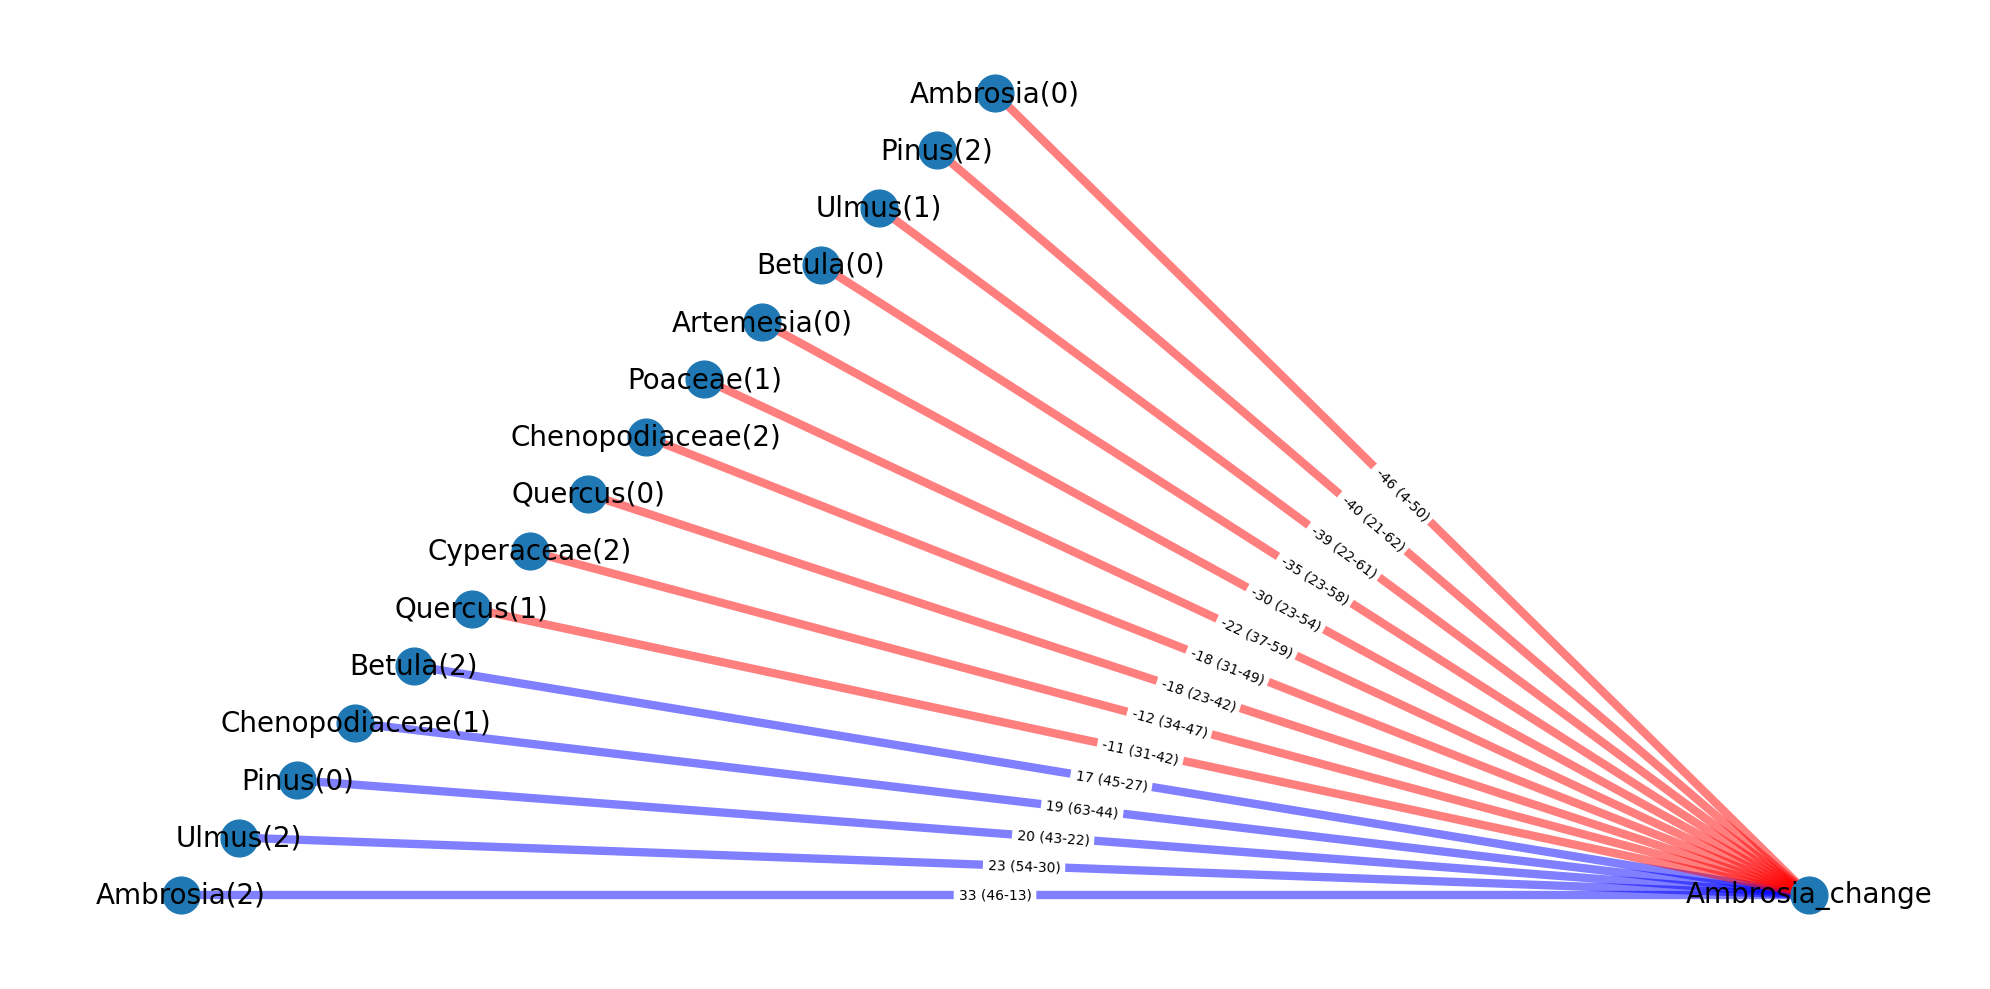

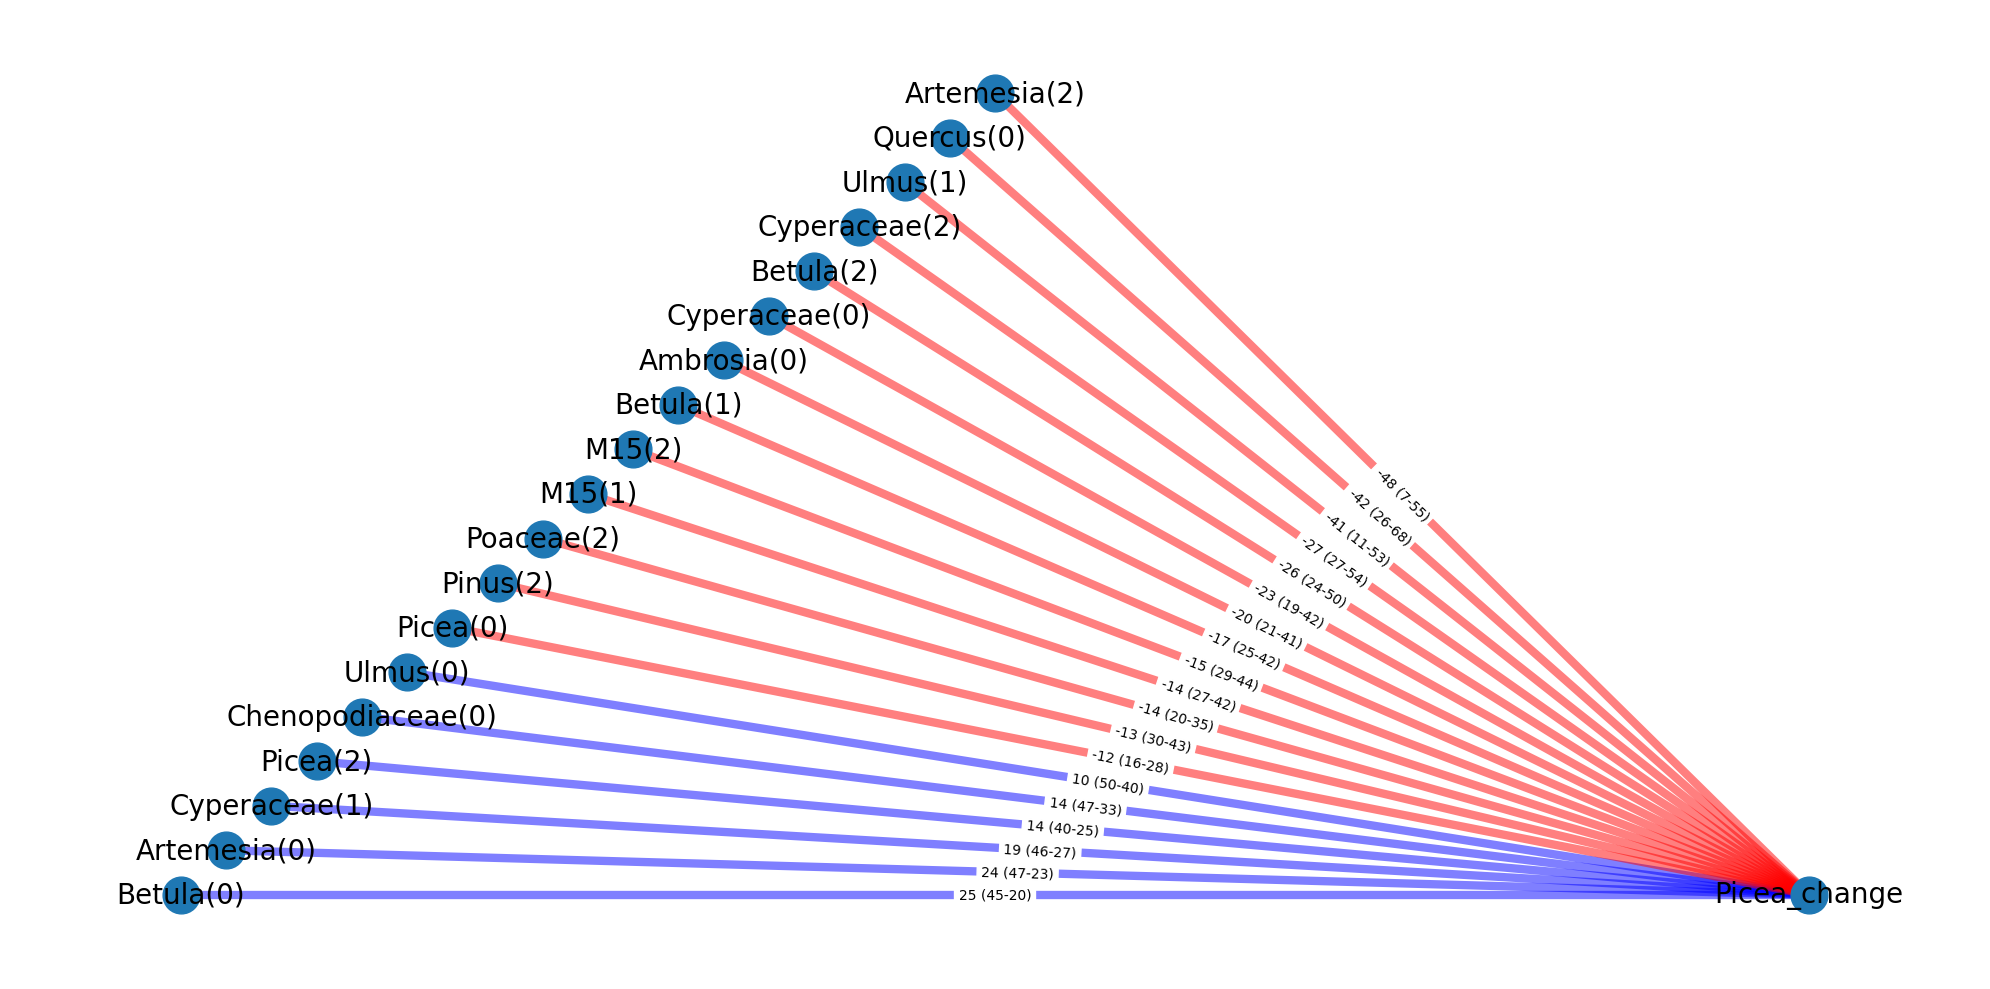

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

for target in df_influences["target"].unique():
    fig, ax = plt.subplots(figsize=(20,10))
    G = nx.Graph()

    MIN_INFLUENCE_SUPPORT = 10

    df_tmp = df_influences[(df_influences["target"] == target) &
                        (df_influences["feature"] != target) &
                        (
                            (df_influences["influence"] >= MIN_INFLUENCE_SUPPORT) |
                            (df_influences["influence"] <= -MIN_INFLUENCE_SUPPORT)
                        )]

    #display(df_tmp)
    for idx, row in df_tmp.iterrows():
        G.add_edge(row["feature"], row["target"], weight=row["influence"], label=str(row["influence"])+" ("+str(int(row["positive_influence"]))+str(int(-row["negative_influence"]))+")")

    positive_edge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] >= MIN_INFLUENCE_SUPPORT]
    negative_edge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= -MIN_INFLUENCE_SUPPORT]

    pos = nx.planar_layout(G)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, ax=ax)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=positive_edge, width=6, alpha=0.5, edge_color="b", ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=negative_edge, width=6, alpha=0.5, edge_color="r", ax=ax)

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif", ax=ax)
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels, ax=ax)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

# TODO